In [1]:
import tensorflow as tf
from vit_keras import vit, utils, visualize
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from IPython.display import Image
from IPython.core.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import label_binarize, LabelBinarizer

import os 
import pandas as pd
import numpy as np
import json
import time
import re
import itertools
import pickle
import csv
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import PIL

In [2]:
experiment = "Mohs_BCC_SCC_2023_propsplit"
best_model = "158"

working_dir = '' # PUT YOUR HOME HERE
processed_data = working_dir + "processed/"
experiment_folder = working_dir + experiment + "/"
model_output_folder = working_dir + experiment + "/" + "model" + "/"

JSON_PATH = model_output_folder + experiment + ".json"
MODEL_WEIGHTS = model_output_folder + experiment + ".0." + best_model + "_cp.ckpt" # CHANGE ME

with open(experiment_folder+'MODEL_PARAMETERS.txt','r') as f:
    model_file = f.read()        
    MODEL_PARAMETERS = eval(model_file)

MODEL_PARAMETERS

{'model_name': 'Mohs_BCC_SCC_2023_propsplit',
 'image_size': 512,
 'loss': 'categorical_crossentropy',
 'class_mode': 'categorical',
 'output_layers': 3,
 'output_activation': 'softmax',
 'activation': 'relu',
 'optimizer': 'sgd',
 'num_epochs': 30,
 'batch_size': 4}

In [3]:
''' Helper Functions '''

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
    
def plot_image(file_path= None, public_url = None, max_size = [500,500]):

    if file_path is None and public_url is None:
        exit("Either file_path or public_url must be provided")
        
    if file_path is not None and public_url is not None:
        exit("Either file_path or public_url must be provided")
    
    if public_url is not None:
        response = requests.get(public_url)
        img = PIL.Image.open(BytesIO(response.content))
    
    if file_path is not None:
        img = PIL.Image.open(file_path)

    if max_size is not None:
        img.thumbnail(max_size)

    img.show()

def string_to_float_array(s):
    return np.array(list(map(float, s.strip('[]').split())))

# Tweaked from https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
# Changed the percent calculation to be the percent within each class, IE accuracy for each class
# Before it was calculating the percent within that box, which is kinda of not useful
# Fixed the color score to be based on percentages when colored, instead of the counts

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None, 
                          write_out = False,
                          experiment_folder = experiment_folder,
                          file_name = "confusion",
                          dpi = 300):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    Percent:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html            
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        # The original percent calculation is here, but its no good
        # group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
        # Fixed below
        cm_norm = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
        group_percentages = cm_norm.flatten()
        group_percentages = np.around(group_percentages, 2)
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False

    # Fix to color by percentages
    if percent:
        cf = cm_norm
        
    # MAKE THE HEATMAP VISUALIZATION
    
    plt.figure(figsize=figsize)
    
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
        
    if write_out:
        
        plt.savefig(experiment_folder + file_name + '.pdf', dpi=dpi)
        plt.close()
        
        
        
def load_model(JSON_PATH, MODEL_WEIGHTS):
    """
    :param COND_MODEL_JSON_PTH: (str) path to json model file
    :param COND_MODEL_WEIGHTS_PTH:  (str) path to model weights file
    :return: condition model
    """

    print("JSON LOAD")
    cond_json_file = open(JSON_PATH, "r")
    cond_loaded_model_json = cond_json_file.read()
    cond_json_file.close()

    print("CREATE MODEL FROM JSON")
    cond_model = tf.keras.models.model_from_json(cond_loaded_model_json)
    
    print("LOAD WEIGHTS INTO MODEL")
    cond_model.load_weights(MODEL_WEIGHTS)
    print("type of cond model", type(cond_model))
    return cond_model

def image_inference(img_pth, model, image_size = 512):
    """
    :param img_pth: (str) path to image file for inference
    :return: (float) condition score for image
    """
    img = tf.keras.preprocessing.image.load_img(img_pth, target_size=(image_size, image_size))
    x = tf.keras.preprocessing.image.img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
    x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
    x = x / 255
    result = model.predict(x, batch_size=1, verbose = 0)
    result = result[0]
    return(result)

In [4]:
''' MODEL 1 LOAD DATA RESULTS '''

model = load_model(JSON_PATH, MODEL_WEIGHTS)


JSON LOAD
CREATE MODEL FROM JSON
LOAD WEIGHTS INTO MODEL
type of cond model <class 'keras.engine.functional.Functional'>


In [5]:
val_df = pd.read_csv(experiment_folder + "val_data.csv", index_col=0)
print(Counter(val_df["patch_cancer"]))
val_df.reset_index(inplace=True, drop = True)

val_df

Counter({'N': 291, 'B': 74, 'S': 37})


full_path  \
0    /home/ubuntu/Data/MOHS/processed/6_A_10x_N_9_p...   
1    /home/ubuntu/Data/MOHS/processed/14_A_10x_N_43...   
2    /home/ubuntu/Data/MOHS/processed/12_B_10x_BCC_...   
3    /home/ubuntu/Data/MOHS/processed/1_A_10x_N_1_p...   
4    /home/ubuntu/Data/MOHS/processed/12_B_10x_BCC_...   
..                                                 ...   
397  /home/ubuntu/Data/MOHS/processed/3_A_10x_N_40_...   
398  /home/ubuntu/Data/MOHS/processed/11_D_10x_N_73...   
399  /home/ubuntu/Data/MOHS/processed/15_B_10x_N_2_...   
400  /home/ubuntu/Data/MOHS/processed/11_D_10x_N_37...   
401  /home/ubuntu/Data/MOHS/processed/15_A_10x_N_6_...   

                    image_name               metadata  patient slide zoom  \
0        6_A_10x_N_9_p_1_N.jpg      6_A_10x_N_9_p_1_N        6     A  10x   
1      14_A_10x_N_43_p_2_N.jpg    14_A_10x_N_43_p_2_N       14     A  10x   
2    12_B_10x_BCC_11_p_2_N.jpg  12_B_10x_BCC_11_p_2_N       12     B  10x   
3        1_A_10x_N_1_p_1_N.jpg      1_A_10x_N_1_p_1_N        1     A  10x   
4    12_B_10x_BCC_18_p_4_B.jpg  12_B_10x_BCC_18_p_4_B       12     B  10x   
..                         ...                    ...      ...   ...  ...   
397     3_A_10x_N_40_p_3_N.jpg     3_A_10x_N_40_p_3_N        3     A  10x   
398    11_D_10x_N_73_p_3_N.jpg    11_D_10x_N_73_p_3_N       11     D  10x   
399     15_B_10x_N_2_p_3_N.jpg     15_B_10x_N_2_p_3_N       15     B  10x   
400    11_D_10x_N_37_p_4_N.jpg    11_D_10x_N_37_p_4_N       11     D  10x   
401     15_A_10x_N_6_p_1_N.jpg     15_A_10x_N_6_p_1_N       15     A  10x   

    cancer  image_number  patch_number patch_cancer class_set  
0        N             9             1            N       val  
1        N            43             2            N       val  
2      BCC            11             2            N       val  
3        N             1             1            N       val  
4      BCC            18             4            B       val  
..     ...           ...           ...          ...       ...  
397      N            40             3            N       val  
398      N            73             3            N       val  
399      N             2             3            N       val  
400      N            37             4            N       val  
401      N             6             1            N       val  

[402 rows x 11 columns]

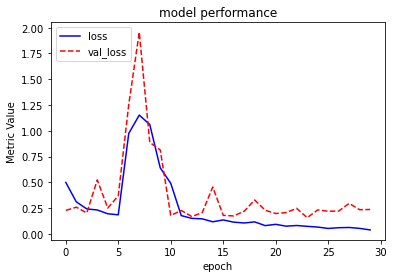

"\nwidth_inch = 6\nheight_inch = 4\ndpi = 300\nplt.figure(figsize=(width_inch, height_inch))\nplt.savefig(experiment_folder + 'model_training.pdf', dpi=dpi)\nplt.close()\n"

In [6]:
with open(model_output_folder+"trainHistoryDict", 'rb') as pickle_file:
    history = pickle.load(pickle_file)
    
width_inch = 6
height_inch = 4
dpi = 300

plt.figure(figsize=(width_inch, height_inch))

plt.plot(history['loss'], color = "blue")
plt.plot(history['val_loss'],color = "red", ls = "dashed")
                      
plt.title('model performance')
plt.ylabel('Metric Value')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()
# plt.savefig(experiment_folder + 'model_training.pdf', dpi=dpi)
# plt.close()

'''
width_inch = 6
height_inch = 4
dpi = 300
plt.figure(figsize=(width_inch, height_inch))
plt.savefig(experiment_folder + 'model_training.pdf', dpi=dpi)
plt.close()
'''


In [ ]:

classes_dictionary = {0 : 'B',
                      1 : 'N', 
                      2 : 'S'}

val_df["Prediction"] = ""
val_df["Probabilities"] = ""

for index in val_df.index: 
    
    if index % 100 == 0:
        print("Starting " + str(index))
    predict = image_inference(val_df["full_path"][index], model)

    val_df.at[index, "Probabilities"] = predict
    
    high_Score = (np.argmax(predict))
    pred = classes_dictionary[high_Score]
    val_df.at[index, "Prediction"] = pred

Counter(val_df["Prediction"])


val_df.to_csv(model_output_folder + "val_data_predictions.csv")


In [7]:
val_df = pd.read_csv(model_output_folder + "val_data_predictions.csv", index_col=0)
val_df

full_path  \
0    /home/ubuntu/Data/MOHS/processed/6_A_10x_N_9_p...   
1    /home/ubuntu/Data/MOHS/processed/14_A_10x_N_43...   
2    /home/ubuntu/Data/MOHS/processed/12_B_10x_BCC_...   
3    /home/ubuntu/Data/MOHS/processed/1_A_10x_N_1_p...   
4    /home/ubuntu/Data/MOHS/processed/12_B_10x_BCC_...   
..                                                 ...   
397  /home/ubuntu/Data/MOHS/processed/3_A_10x_N_40_...   
398  /home/ubuntu/Data/MOHS/processed/11_D_10x_N_73...   
399  /home/ubuntu/Data/MOHS/processed/15_B_10x_N_2_...   
400  /home/ubuntu/Data/MOHS/processed/11_D_10x_N_37...   
401  /home/ubuntu/Data/MOHS/processed/15_A_10x_N_6_...   

                    image_name               metadata  patient slide zoom  \
0        6_A_10x_N_9_p_1_N.jpg      6_A_10x_N_9_p_1_N        6     A  10x   
1      14_A_10x_N_43_p_2_N.jpg    14_A_10x_N_43_p_2_N       14     A  10x   
2    12_B_10x_BCC_11_p_2_N.jpg  12_B_10x_BCC_11_p_2_N       12     B  10x   
3        1_A_10x_N_1_p_1_N.jpg      1_A_10x_N_1_p_1_N        1     A  10x   
4    12_B_10x_BCC_18_p_4_B.jpg  12_B_10x_BCC_18_p_4_B       12     B  10x   
..                         ...                    ...      ...   ...  ...   
397     3_A_10x_N_40_p_3_N.jpg     3_A_10x_N_40_p_3_N        3     A  10x   
398    11_D_10x_N_73_p_3_N.jpg    11_D_10x_N_73_p_3_N       11     D  10x   
399     15_B_10x_N_2_p_3_N.jpg     15_B_10x_N_2_p_3_N       15     B  10x   
400    11_D_10x_N_37_p_4_N.jpg    11_D_10x_N_37_p_4_N       11     D  10x   
401     15_A_10x_N_6_p_1_N.jpg     15_A_10x_N_6_p_1_N       15     A  10x   

    cancer  image_number  patch_number patch_cancer class_set Prediction  \
0        N             9             1            N       val          N   
1        N            43             2            N       val          N   
2      BCC            11             2            N       val          N   
3        N             1             1            N       val          N   
4      BCC            18             4            B       val          B   
..     ...           ...           ...          ...       ...        ...   
397      N            40             3            N       val          N   
398      N            73             3            N       val          N   
399      N             2             3            N       val          N   
400      N            37             4            N       val          N   
401      N             6             1            N       val          N   

                                   Probabilities  
0    [9.9340206e-05 9.9990058e-01 1.6296374e-07]  
1    [2.9745367e-03 9.9680173e-01 2.2372643e-04]  
2    [1.1609828e-01 8.8388807e-01 1.3634309e-05]  
3    [3.4779713e-02 9.6520430e-01 1.5979216e-05]  
4    [9.9999654e-01 3.4078839e-06 5.8676324e-08]  
..                                           ...  
397           [0.00573689 0.98895824 0.00530485]  
398     [6.792115e-03 9.932064e-01 1.567026e-06]  
399           [0.01302314 0.9859103  0.00106658]  
400  [2.9144165e-04 9.9964154e-01 6.6983135e-05]  
401  [9.5729291e-04 9.9898881e-01 5.3955064e-05]  

[402 rows x 13 columns]

Accuracy Score is 0.9577114427860697
              precision    recall  f1-score   support

           B       0.89      0.91      0.90        74
           N       0.97      0.97      0.97       291
           S       0.97      0.95      0.96        37

    accuracy                           0.96       402
   macro avg       0.95      0.94      0.94       402
weighted avg       0.96      0.96      0.96       402



'\nmake_confusion_matrix(cf_matrix, \n                      percent = True, \n                      count= True, \n                      categories = classes_dictionary.values(), \n                      title = "Confusion Matrix", \n                      write_out = True,\n                      file_name = "confusion_argmax")\n'

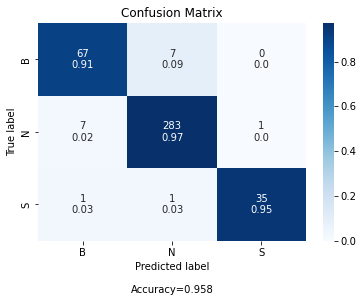

In [8]:
''' MODEL 1 QC PREDICTIONS'''

classes_dictionary = {0 : 'B',
                      1 : 'N', 
                      2 : 'S'}

truth = val_df["patch_cancer"]
prediction = val_df["Prediction"]

correct_labels = truth == prediction
val_df["Correct"] = correct_labels
Counter(val_df["Correct"])

print(color.GREEN + "Accuracy Score is " + str(accuracy_score(truth, prediction)))
    
print(color.GREEN + classification_report(truth, prediction))
    
cf_matrix = confusion_matrix(truth, prediction)

make_confusion_matrix(cf_matrix, 
                      percent = True, 
                      count= True, 
                      categories = classes_dictionary.values(), 
                      title = "Confusion Matrix", 
                      write_out = False)
'''
make_confusion_matrix(cf_matrix, 
                      percent = True, 
                      count= True, 
                      categories = classes_dictionary.values(), 
                      title = "Confusion Matrix", 
                      write_out = True,
                      file_name = "confusion_argmax")
'''

In [ ]:
''' MODEL 1 QC PREDICTIONS'''

patients = list(val_df['patient'].unique())

for patient in patients:

    print(color.BLUE + str(patient))

    desired_rows = val_df[val_df['patient'] == patient]
    truth = desired_rows["patch_cancer"]
    prediction = desired_rows["Prediction"]
    
    correct_labels = truth == prediction
    desired_rows["Correct"] = correct_labels
    Counter(desired_rows["Correct"])
    
    print(color.PURPLE + "Accuracy Score is " + str(accuracy_score(truth, prediction)))
        
    print(color.DARKCYAN + classification_report(truth, prediction))
        
    cf_matrix = confusion_matrix(truth, prediction)
        
    print(make_confusion_matrix(cf_matrix, percent=True, count=True, categories=classes_dictionary.values(), title="Confusion Matrix"))

In [9]:
# ROC Curve pre-processing steps

truth = val_df["patch_cancer"]
prediction = val_df["Prediction"]
classes_list = list(classes_dictionary.values())
y_score = np.array(val_df["Probabilities"])
numerical_array = np.array([string_to_float_array(s) for s in y_score])
y_score = np.concatenate(numerical_array).reshape(-1, 3)
n_classes = len(classes_list)


label_binarizer = LabelBinarizer().fit(val_df["patch_cancer"])
y_onehot_test = label_binarize(truth, classes=classes_list)  # 'classes_list' should contain all the possible classes in your multiclass problem


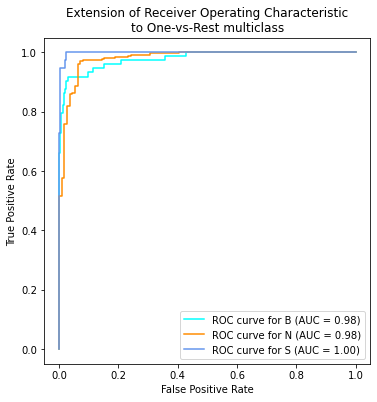

In [10]:

# All for one vs one for all motherfucka

fig, ax = plt.subplots(figsize=(6, 6))

colors = itertools.cycle(["aqua", "darkorange", "cornflowerblue"])

for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {classes_list[class_id]}",
        color=color,
        ax=ax
       # plot_chance_level=(class_id == 2),
    )




plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()
# plt.savefig(experiment_folder + 'model_ROC.pdf', dpi=dpi)
# plt.close()


In [11]:
val_df = pd.read_csv(model_output_folder + "val_data_predictions.csv", index_col=0)

classes_dictionary = {0 : 'B',
                      1 : 'N', 
                      2 : 'S'}

for index in val_df.index:
    all_probs = string_to_float_array(val_df["Probabilities"][index])
    val_df.at[index, "prob_n"] = all_probs[1]
    val_df.at[index, "prob_b"] = all_probs[0]
    val_df.at[index, "prob_s"] = all_probs[2]

val_df

full_path  \
0    /home/ubuntu/Data/MOHS/processed/6_A_10x_N_9_p...   
1    /home/ubuntu/Data/MOHS/processed/14_A_10x_N_43...   
2    /home/ubuntu/Data/MOHS/processed/12_B_10x_BCC_...   
3    /home/ubuntu/Data/MOHS/processed/1_A_10x_N_1_p...   
4    /home/ubuntu/Data/MOHS/processed/12_B_10x_BCC_...   
..                                                 ...   
397  /home/ubuntu/Data/MOHS/processed/3_A_10x_N_40_...   
398  /home/ubuntu/Data/MOHS/processed/11_D_10x_N_73...   
399  /home/ubuntu/Data/MOHS/processed/15_B_10x_N_2_...   
400  /home/ubuntu/Data/MOHS/processed/11_D_10x_N_37...   
401  /home/ubuntu/Data/MOHS/processed/15_A_10x_N_6_...   

                    image_name               metadata  patient slide zoom  \
0        6_A_10x_N_9_p_1_N.jpg      6_A_10x_N_9_p_1_N        6     A  10x   
1      14_A_10x_N_43_p_2_N.jpg    14_A_10x_N_43_p_2_N       14     A  10x   
2    12_B_10x_BCC_11_p_2_N.jpg  12_B_10x_BCC_11_p_2_N       12     B  10x   
3        1_A_10x_N_1_p_1_N.jpg      1_A_10x_N_1_p_1_N        1     A  10x   
4    12_B_10x_BCC_18_p_4_B.jpg  12_B_10x_BCC_18_p_4_B       12     B  10x   
..                         ...                    ...      ...   ...  ...   
397     3_A_10x_N_40_p_3_N.jpg     3_A_10x_N_40_p_3_N        3     A  10x   
398    11_D_10x_N_73_p_3_N.jpg    11_D_10x_N_73_p_3_N       11     D  10x   
399     15_B_10x_N_2_p_3_N.jpg     15_B_10x_N_2_p_3_N       15     B  10x   
400    11_D_10x_N_37_p_4_N.jpg    11_D_10x_N_37_p_4_N       11     D  10x   
401     15_A_10x_N_6_p_1_N.jpg     15_A_10x_N_6_p_1_N       15     A  10x   

    cancer  image_number  patch_number patch_cancer class_set Prediction  \
0        N             9             1            N       val          N   
1        N            43             2            N       val          N   
2      BCC            11             2            N       val          N   
3        N             1             1            N       val          N   
4      BCC            18             4            B       val          B   
..     ...           ...           ...          ...       ...        ...   
397      N            40             3            N       val          N   
398      N            73             3            N       val          N   
399      N             2             3            N       val          N   
400      N            37             4            N       val          N   
401      N             6             1            N       val          N   

                                   Probabilities    prob_n    prob_b  \
0    [9.9340206e-05 9.9990058e-01 1.6296374e-07]  0.999901  0.000099   
1    [2.9745367e-03 9.9680173e-01 2.2372643e-04]  0.996802  0.002975   
2    [1.1609828e-01 8.8388807e-01 1.3634309e-05]  0.883888  0.116098   
3    [3.4779713e-02 9.6520430e-01 1.5979216e-05]  0.965204  0.034780   
4    [9.9999654e-01 3.4078839e-06 5.8676324e-08]  0.000003  0.999997   
..                                           ...       ...       ...   
397           [0.00573689 0.98895824 0.00530485]  0.988958  0.005737   
398     [6.792115e-03 9.932064e-01 1.567026e-06]  0.993206  0.006792   
399           [0.01302314 0.9859103  0.00106658]  0.985910  0.013023   
400  [2.9144165e-04 9.9964154e-01 6.6983135e-05]  0.999642  0.000291   
401  [9.5729291e-04 9.9898881e-01 5.3955064e-05]  0.998989  0.000957   

           prob_s  
0    1.629637e-07  
1    2.237264e-04  
2    1.363431e-05  
3    1.597922e-05  
4    5.867632e-08  
..            ...  
397  5.304850e-03  
398  1.567026e-06  
399  1.066580e-03  
400  6.698313e-05  
401  5.395506e-05  

[402 rows x 16 columns]

5_A_10x_BCC_2_p_4_B
[4.4866082e-01 5.5133605e-01 3.1475874e-06]


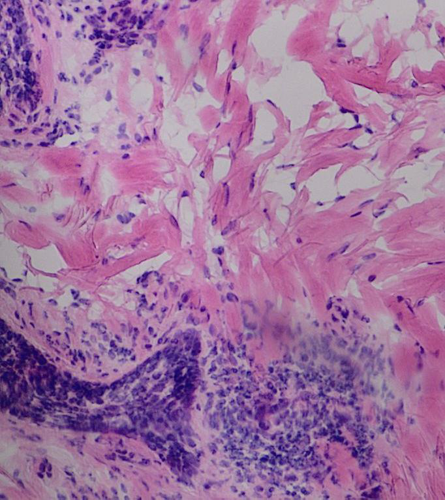

4_A_10x_BCC_1_p_5_B
[6.5260179e-02 9.3473947e-01 3.5074325e-07]


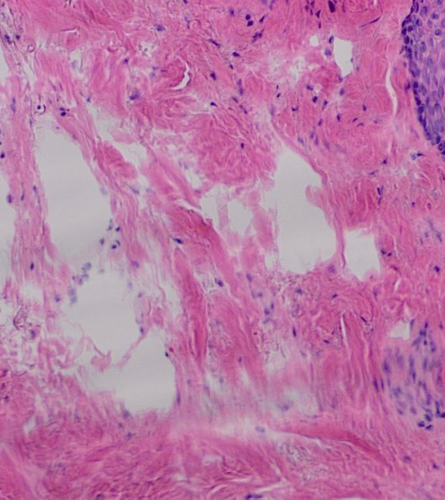

11_C_10x_BCC_13_p_6_B
[4.2642422e-02 9.5675516e-01 6.0247077e-04]


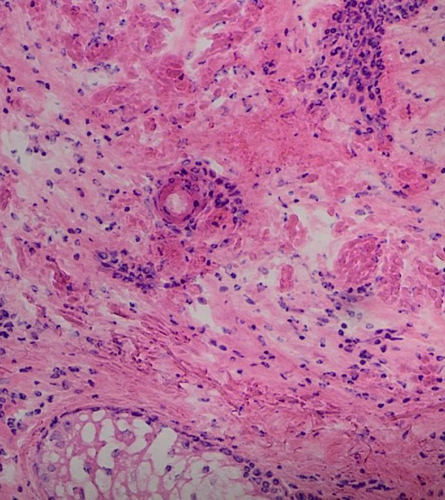

3_A_10x_SCC_42_p_3_S
[0.03911794 0.9376085  0.0232735 ]


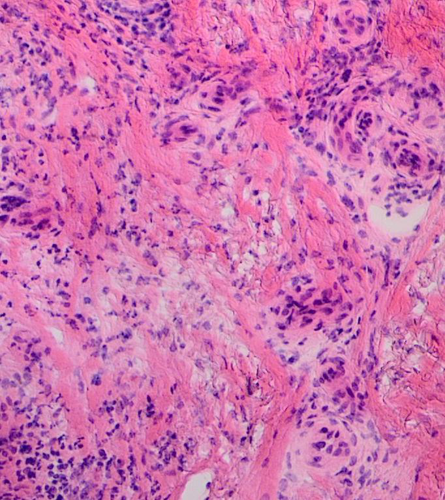

11_D_10x_BCC_26_p_5_B
[5.0241039e-03 9.9454308e-01 4.3288287e-04]


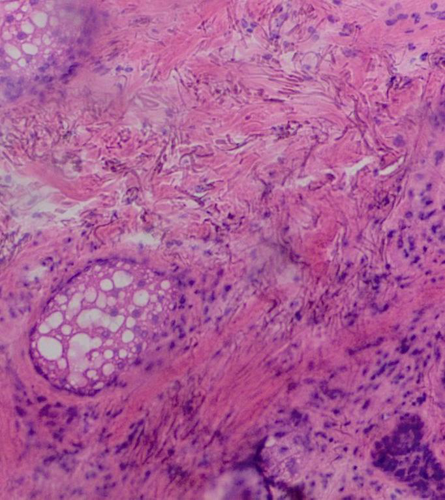

11_D_10x_BCC_12_p_1_B
[8.2335239e-03 9.9176401e-01 2.5099346e-06]


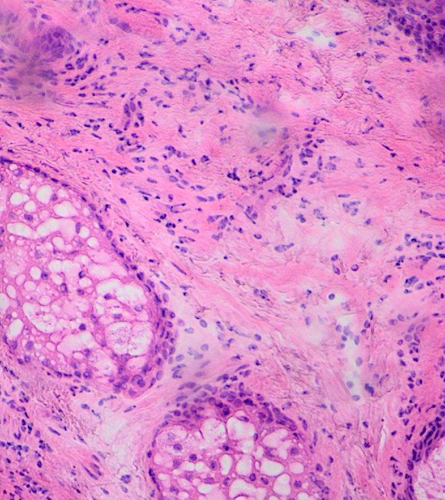

2_A_10x_BCC_4_p_5_B
[9.6513137e-02 9.0348464e-01 2.2830804e-06]


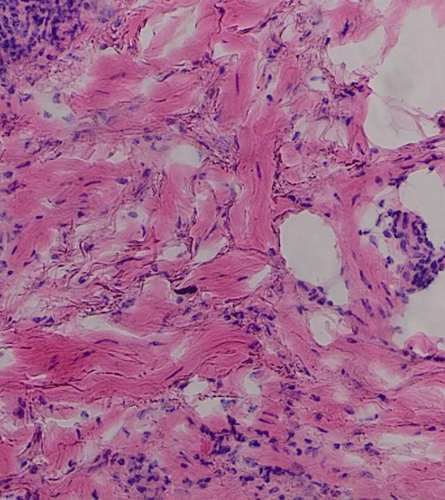

12_B_10x_BCC_5_p_5_B
[3.0183800e-02 9.6978819e-01 2.8024613e-05]


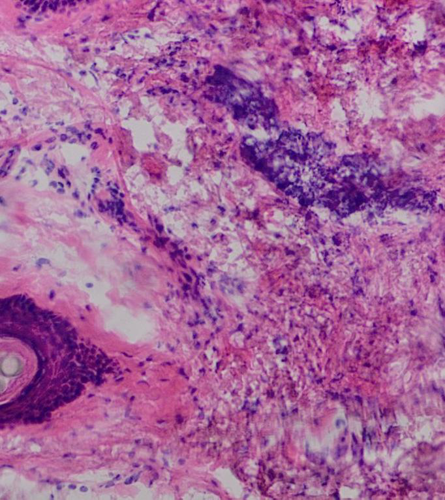

0.99454308

In [12]:
# Pseudocode

# Looking at samples classified as N, that were B or S
# Find the threshold

classes_dictionary = {0 : 'B',
                      1 : 'N', 
                      2 : 'S'}

# Find the threshold
# Looking at samples classified as N, that were B or S

false_negatives = val_df[(val_df['patch_cancer'].isin(['B', 'S'])) & (val_df['Prediction'] == 'N')]
false_negatives.reset_index(drop = True, inplace = True)
max_prob = 0

for index in false_negatives.index:
    print(false_negatives["metadata"][index])
    print(false_negatives["Probabilities"][index])
    plot_image(false_negatives["full_path"][index])
    current_n_prob = (string_to_float_array(false_negatives["Probabilities"][index])[1])
    if current_n_prob > max_prob:
        max_prob = current_n_prob
        
max_prob  

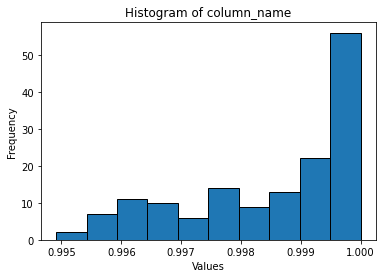

150


In [13]:
# Create the histogram
all_n = val_df['prob_n']
greater_than_threshold = [value for value in all_n if value > max_prob]
greater_than_threshold

plt.hist(greater_than_threshold, bins=10, edgecolor='black')

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of column_name')

# Show the plot
plt.show()

print(len(greater_than_threshold))

In [14]:
# Pseudocode

# Loop through the Dataframe
# IF cancer is N,
# IF prob is < thresh
# Get max cancer instead
# Assign cancer
count = 0

val_df["Prediction_stringent"] = val_df["Prediction"]

for index in val_df.index:
    if val_df["Prediction"][index] == "N":
        if val_df["prob_n"][index] <= max_prob:
            if val_df["prob_b"][index] > val_df["prob_s"][index]:
                val_df.at[index,"Prediction_stringent"] = "B"
            else:
                val_df.at[index,"Prediction_stringent"] = "S"
           

Accuracy Score is 0.6442786069651741
              precision    recall  f1-score   support

           B       0.37      1.00      0.54        74
           N       1.00      0.52      0.68       291
           S       0.69      0.95      0.80        37

    accuracy                           0.64       402
   macro avg       0.68      0.82      0.67       402
weighted avg       0.85      0.64      0.66       402



'\nmake_confusion_matrix(cf_matrix, \n                      percent = True, \n                      count= True, \n                      categories = classes_dictionary.values(), \n                      title = "Confusion Matrix",\n                      write_out = True,\n                      file_name = "confusion_stringent")\n'

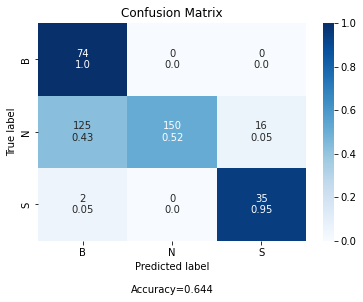

In [15]:
''' MODEL 1 QC PREDICTIONS'''

truth = val_df["patch_cancer"]
prediction = val_df["Prediction_stringent"]

correct_labels = truth == prediction
val_df["Correct"] = correct_labels
Counter(val_df["Correct"])

print("Accuracy Score is " + str(accuracy_score(truth, prediction)))
    
print(classification_report(truth, prediction))
    
cf_matrix = confusion_matrix(truth, prediction)

make_confusion_matrix(cf_matrix, 
                      percent = True, 
                      count= True, 
                      categories = classes_dictionary.values(), 
                      title = "Confusion Matrix",
                      write_out = False)
   
'''
make_confusion_matrix(cf_matrix, 
                      percent = True, 
                      count= True, 
                      categories = classes_dictionary.values(), 
                      title = "Confusion Matrix",
                      write_out = True,
                      file_name = "confusion_stringent")
'''

In [16]:
patch_cancer_values = ['B', 'S', 'N']
prediction_values = ['B', 'S', 'N']

# Generate all permutations of the values using itertools.product()
all_combinations = list(itertools.product(patch_cancer_values, prediction_values))

# Create an empty DataFrame to store the filtered results
result_df = pd.DataFrame(columns=val_df.columns)

all_combinations.pop(1)

all_combinations

[('B', 'B'),
 ('B', 'N'),
 ('S', 'B'),
 ('S', 'S'),
 ('S', 'N'),
 ('N', 'B'),
 ('N', 'S'),
 ('N', 'N')]

In [17]:
prob_dictionary = {'B' : 0,
                   'N': 1, 
                   'S': 2}

keep_rows = []

# Iterate through all the combinations and filter the DataFrame
for combination in all_combinations:
    
    print(combination)
    
    patch_cancer_value, prediction_value = combination
    
    filtered_rows = val_df[
        (val_df['patch_cancer'] == patch_cancer_value) & (val_df['Prediction'] == prediction_value)
    ]
    
    max_prob = 0
    
    print(len(filtered_rows))
            
    if len(filtered_rows) > 0:
        
        for index in filtered_rows.index:

            current_probs = filtered_rows["Probabilities"][index]
            
            current_probs = string_to_float_array(current_probs)
            
            current_prob = current_probs[prob_dictionary[combination[1]]]
            
            if current_prob > max_prob:
                
                keep_row = index
                
    print(keep_row)
                
    keep_rows.append(keep_row)
    
keep_rows          

('B', 'B')
67
390
('B', 'N')
7
321
('S', 'B')
1
350
('S', 'S')
35
389
('S', 'N')
1
205
('N', 'B')
7
361
('N', 'S')
1
312
('N', 'N')
283
401


[390, 321, 350, 389, 205, 361, 312, 401]

In [ ]:
conf_matrix_images = val_df.iloc[keep_rows]
conf_matrix_images.reset_index(inplace = True, drop = True)
conf_matrix_images
# conf_matrix_images.to_csv(experiment_folder + "confusion_matrix_images.csv")

In [18]:
conf_matrix_images = pd.read_csv(experiment_folder + "confusion_matrix_images.csv", index_col=0)

conf_matrix_images

full_path  \
0  /home/ubuntu/Data/MOHS/processed/12_A_10x_BCC_...   
1  /home/ubuntu/Data/MOHS/processed/12_B_10x_BCC_...   
2  /home/ubuntu/Data/MOHS/processed/17_A_10x_SCC_...   
3  /home/ubuntu/Data/MOHS/processed/7_A_10x_SCC_1...   
4  /home/ubuntu/Data/MOHS/processed/3_A_10x_SCC_4...   
5  /home/ubuntu/Data/MOHS/processed/2_A_10x_N_5_p...   
6  /home/ubuntu/Data/MOHS/processed/20_A_10x_N_1_...   
7  /home/ubuntu/Data/MOHS/processed/15_A_10x_N_6_...   

                 image_name              metadata  patient slide zoom cancer  \
0  12_A_10x_BCC_7_p_2_B.jpg  12_A_10x_BCC_7_p_2_B       12     A  10x    BCC   
1  12_B_10x_BCC_5_p_5_B.jpg  12_B_10x_BCC_5_p_5_B       12     B  10x    BCC   
2  17_A_10x_SCC_8_p_2_S.jpg  17_A_10x_SCC_8_p_2_S       17     A  10x    SCC   
3  7_A_10x_SCC_12_p_4_S.jpg  7_A_10x_SCC_12_p_4_S        7     A  10x    SCC   
4  3_A_10x_SCC_42_p_3_S.jpg  3_A_10x_SCC_42_p_3_S        3     A  10x    SCC   
5     2_A_10x_N_5_p_6_N.jpg     2_A_10x_N_5_p_6_N        2     A  10x      N   
6    20_A_10x_N_1_p_6_N.jpg    20_A_10x_N_1_p_6_N       20     A  10x      N   
7    15_A_10x_N_6_p_1_N.jpg    15_A_10x_N_6_p_1_N       15     A  10x      N   

   image_number  patch_number patch_cancer class_set Prediction  \
0             7             2            B       val          B   
1             5             5            B       val          N   
2             8             2            S       val          B   
3            12             4            S       val          S   
4            42             3            S       val          N   
5             5             6            N       val          B   
6             1             6            N       val          S   
7             6             1            N       val          N   

                                 Probabilities    prob_n    prob_b    prob_s  \
0  [9.9985254e-01 1.4564356e-04 1.7333348e-06]  0.000146  0.999853  0.000002   
1  [3.0183800e-02 9.6978819e-01 2.8024613e-05]  0.969788  0.030184  0.000028   
2           [0.9456782  0.02380223 0.03051957]  0.023802  0.945678  0.030520   
3  [4.5844266e-04 1.7603023e-02 9.8193860e-01]  0.017603  0.000458  0.981939   
4           [0.03911794 0.9376085  0.0232735 ]  0.937608  0.039118  0.023273   
5  [9.7701049e-01 2.2980016e-02 9.5258620e-06]  0.022980  0.977010  0.000010   
6  [1.5090006e-04 6.4371437e-02 9.3547767e-01]  0.064371  0.000151  0.935478   
7  [9.5729291e-04 9.9898881e-01 5.3955064e-05]  0.998989  0.000957  0.000054   

  Prediction_stringent  Correct  
0                    B     True  
1                    B     True  
2                    B    False  
3                    S     True  
4                    B    False  
5                    B    False  
6                    S    False  
7                    N     True

12_A_10x_BCC_7_p_2_B
True Label :    B
Pred Label :    B


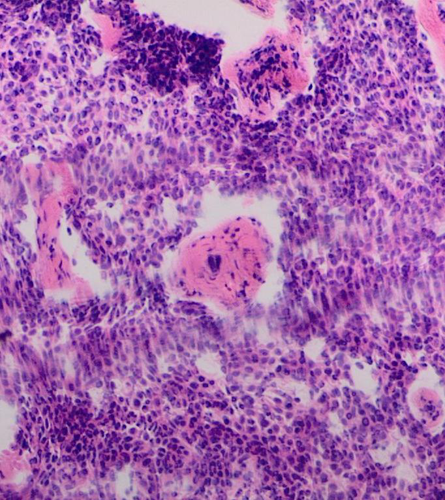

12_B_10x_BCC_5_p_5_B
True Label :    B
Pred Label :    N


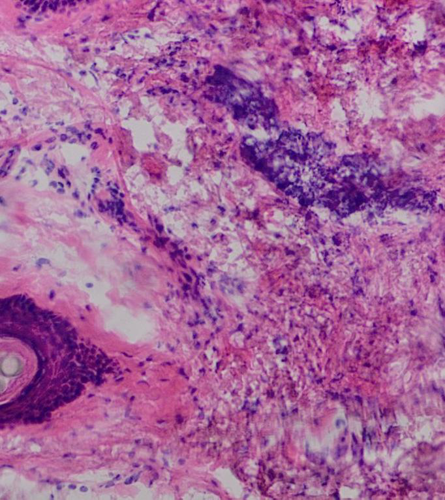

17_A_10x_SCC_8_p_2_S
True Label :    S
Pred Label :    B


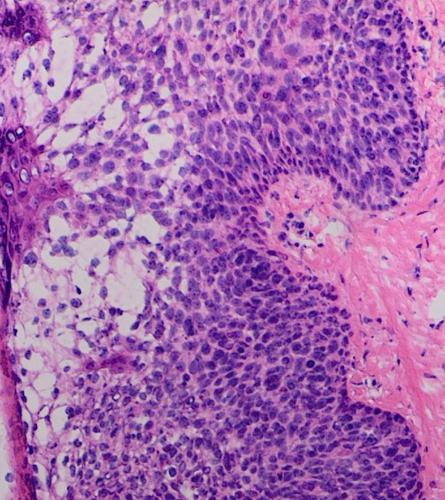

7_A_10x_SCC_12_p_4_S
True Label :    S
Pred Label :    S


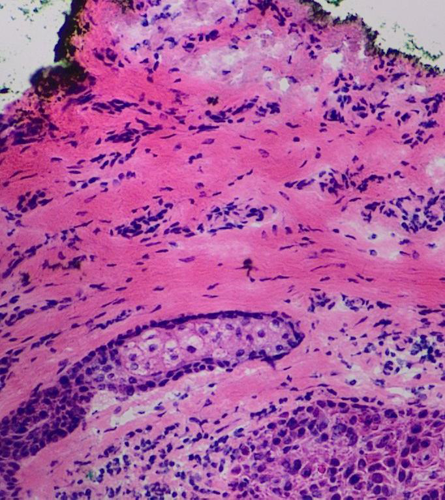

3_A_10x_SCC_42_p_3_S
True Label :    S
Pred Label :    N


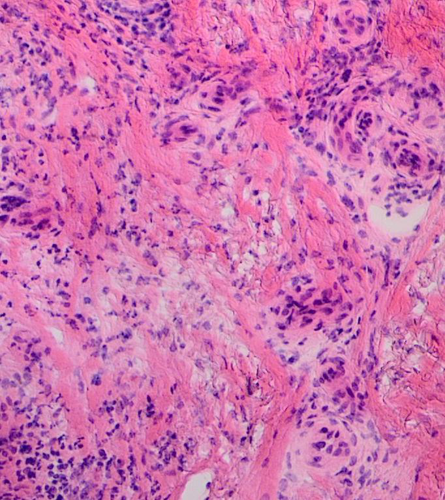

2_A_10x_N_5_p_6_N
True Label :    N
Pred Label :    B


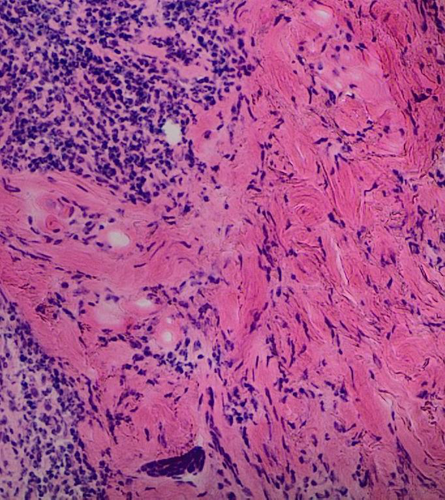

20_A_10x_N_1_p_6_N
True Label :    N
Pred Label :    S


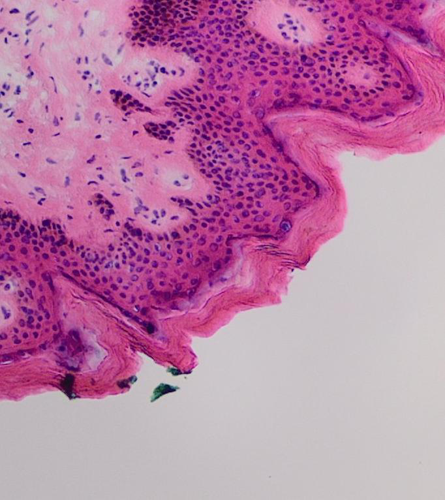

15_A_10x_N_6_p_1_N
True Label :    N
Pred Label :    N


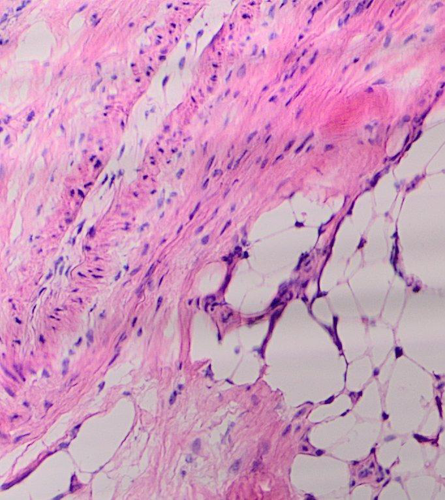

In [19]:
for index in conf_matrix_images.index:
    print(conf_matrix_images["metadata"][index])
    print("True Label :    " + str(conf_matrix_images["patch_cancer"][index]))
    print("Pred Label :    " + str(conf_matrix_images["Prediction"][index]))
    plot_image(conf_matrix_images["full_path"][index])